In [1]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import tensorflow
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch import device
from torch import cuda
from torchvision import transforms
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Importing
importing necessary modules

In [2]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
)
train_loader = torch.utils.data.DataLoader(train_set,
    batch_size=4, shuffle=False, num_workers=1)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
)
test_loader = torch.utils.data.DataLoader(test_set,
    batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#Downloading and Loaders

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
img, label = dataiter.next()
num_train = len(train_set)
num_test = len(test_set)
shape = img.shape
classes = train_set.classes

print("There are " +  str(num_train) + " images in the training set, " + str(num_test) + " in the testing set" + " and the shape of the images are: " + str(shape))
print("The following classes in the dataset are: " + str(classes))

There are 50000 images in the training set, 10000 in the testing set and the shape of the images are: torch.Size([4, 3, 32, 32])
The following classes in the dataset are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


training set:


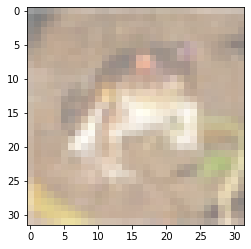

 frog


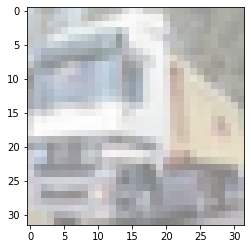

truck


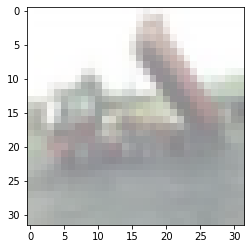

truck


In [4]:
print("training set:")
for i in range(3):
  imshow(torchvision.utils.make_grid(img[i]))
  print("%5s" % classes[label[i]])

#Dataiter

creating an iterator on the loader, img, label on next iteration. show three images.

test set:


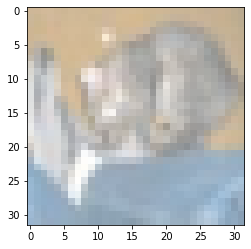

  cat


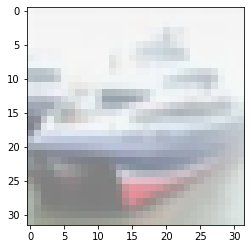

 ship


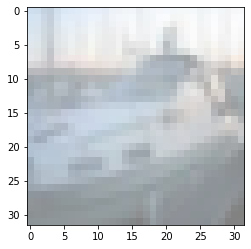

 ship


In [5]:
dataiter = iter(test_loader)
img, label = dataiter.next()
print("test set:")
for i in range(3):
  imshow(torchvision.utils.make_grid(img[i]))
  print("%5s" % classes[label[i]])

In [6]:
random_seed = (55)
validation_size = 5000
training_size = len(train_set) - validation_size

#Splitting 

into training set and validation set with 10% of the training set size for the validation set. In retrospect, if we would've picked a finite number of each class to train, maybe the classifier would behave differently since we cant for certain know, at least in this way, exactly how many pictures of each class its trained on. 

In [7]:
training_dataset, validation_dataset = random_split(train_set, [training_size, validation_size])
len(training_dataset), len(validation_dataset)

(45000, 5000)

#New 

loaders for the datasets, with 4 in each batch.

In [8]:
batch_size=4

train_loader = DataLoader(training_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

#CNN#1
3 input image channels, 6 output channels, 3*3 square convolution kernel. max pooling layer with a 2*2 kernel. second conv2d layer with 16 output channels, three linear layers with corresponding featuers and output features. while the last output of the linear featuers corresponds to number of classes of images.

passing arguments in forward to the the selfs, and flattening the activation tensor via x.view.





In [9]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


network = BaseCNN()

#GPU

Changing the runtime type to GPU to speed up training.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

network.to(device)

cuda:0


BaseCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#Optimizer and criterion

passing the network parameters to the stochastic gradient decent optimizer, with learning rate and momentum.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

#Training function

looping over the dataset, get the inputs, data is a list of [inputs, labels] zeroing the paramater gradients. printing the stats and plotting the loss for the epochs.

In [13]:
def train(epochs, net):
  for epoch in range(epochs):

      running_loss = 0.0
      loss_values = []
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          loss_values.append(running_loss / len(train_loader))
          if i % 2000 == 1999: 
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0
      plt.plot(loss_values)
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train'], loc='upper left')
  print('Finished Training!')

 

#Accuracy test

loop over the test_loader and get the images and labels. Send the images and labels to the device. Forwarding the images to the network, getting the max of the ouput and printing the accuracy of the test images.

In [14]:
def accuracy_test(net):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        

  print('Accuracy on test images: %d %%' % (
      100 * correct / total))

#Label accuracy

prepare to count predictions for each class, iterate over the test loader. We get the images and labels from the test loader, put the images and labels on the GPU, run the images through the network and getting the predictions. We collect the correct predictions for reach class, and count the total number of predictions for each class. lastly, we print.

In [15]:
def label_accuracy(net):

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy on label {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))

[1,  2000] loss: 2.303
[1,  4000] loss: 2.230
[1,  6000] loss: 2.022
[1,  8000] loss: 1.928
[1, 10000] loss: 1.842
[2,  2000] loss: 1.650
[2,  4000] loss: 1.564
[2,  6000] loss: 1.505
[2,  8000] loss: 1.462
[2, 10000] loss: 1.457
[3,  2000] loss: 1.347
[3,  4000] loss: 1.350
[3,  6000] loss: 1.306
[3,  8000] loss: 1.299
[3, 10000] loss: 1.306
[4,  2000] loss: 1.204
[4,  4000] loss: 1.184
[4,  6000] loss: 1.194
[4,  8000] loss: 1.183
[4, 10000] loss: 1.192
[5,  2000] loss: 1.084
[5,  4000] loss: 1.093
[5,  6000] loss: 1.112
[5,  8000] loss: 1.109
[5, 10000] loss: 1.113
[6,  2000] loss: 1.015
[6,  4000] loss: 1.012
[6,  6000] loss: 1.045
[6,  8000] loss: 1.043
[6, 10000] loss: 1.010
[7,  2000] loss: 0.934
[7,  4000] loss: 0.945
[7,  6000] loss: 0.965
[7,  8000] loss: 0.971
[7, 10000] loss: 1.022
[8,  2000] loss: 0.870
[8,  4000] loss: 0.891
[8,  6000] loss: 0.911
[8,  8000] loss: 0.926
[8, 10000] loss: 0.928
[9,  2000] loss: 0.832
[9,  4000] loss: 0.840
[9,  6000] loss: 0.851
[9,  8000] 

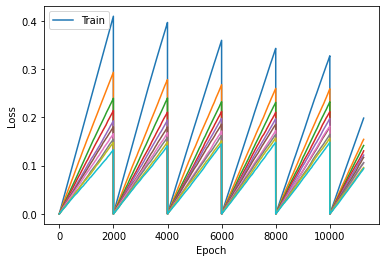

In [16]:
train(10, network)

#Running tests

In [17]:
accuracy_test(network)

Accuracy on test images: 60 %


In [18]:
label_accuracy(network)

Accuracy on label airplane is: 71.5 %
Accuracy on label automobile is: 75.7 %
Accuracy on label bird  is: 34.7 %
Accuracy on label cat   is: 48.1 %
Accuracy on label deer  is: 48.8 %
Accuracy on label dog   is: 59.6 %
Accuracy on label frog  is: 67.4 %
Accuracy on label horse is: 62.1 %
Accuracy on label ship  is: 76.9 %
Accuracy on label truck is: 60.3 %


#Saving to file

In [19]:
PATH = './cifar_10_net.pth'
torch.save(network.state_dict(), PATH)

#CNN#2

As instructed in the task, we add a convolutional layer. There is no need to go through the details since its basically the same as the first. But I want to point out some observations.

When creating the neural nets, I started with the kernel size of 5 * 5, which was switched to 3 * 3. Since the filter size is small, I just tried, and it worked. Many online papers states that smaller kernel sizes should be a popular choice over lager ones. Before this, I tried with different learning rates for the different networks, but yielded the result of nan.

The addition of a convolutional layer clearly shows improvement in both loss and accuracy which are shown in the loss plots and the accuracy tests. Training on the GPU surely sped up the process significally.



In [20]:
class SecondCNN(BaseCNN):
    def __init__(self):
      super(SecondCNN, self).__init__()
      self.conv1 = nn.Conv2d(3, 6, 3)
      self.pool = nn.MaxPool2d(1, 1)
      self.conv2 = nn.Conv2d(6, 16, 3)
      self.conv3 = nn.Conv2d(16, 32, 3)
      self.fc1 = nn.Linear(21632, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [21]:
secondCNN = SecondCNN()
secondCNN.to(device)

SecondCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(secondCNN.parameters(), lr=0.001, momentum=0.9)

[1,  2000] loss: 0.160
[1,  4000] loss: 0.154
[1,  6000] loss: 0.198
[1,  8000] loss: 0.208
[1, 10000] loss: 0.210
[2,  2000] loss: 0.116
[2,  4000] loss: 0.181
[2,  6000] loss: 0.179
[2,  8000] loss: 0.186
[2, 10000] loss: 0.211
[3,  2000] loss: 0.102
[3,  4000] loss: 0.142
[3,  6000] loss: 0.145
[3,  8000] loss: 0.161
[3, 10000] loss: 0.170
[4,  2000] loss: 0.076
[4,  4000] loss: 0.102
[4,  6000] loss: 0.122
[4,  8000] loss: 0.155
[4, 10000] loss: 0.149
[5,  2000] loss: 0.083
[5,  4000] loss: 0.102
[5,  6000] loss: 0.102
[5,  8000] loss: 0.119
[5, 10000] loss: 0.138
[6,  2000] loss: 0.063
[6,  4000] loss: 0.076
[6,  6000] loss: 0.114
[6,  8000] loss: 0.118
[6, 10000] loss: 0.142
[7,  2000] loss: 0.064
[7,  4000] loss: 0.066
[7,  6000] loss: 0.104
[7,  8000] loss: 0.107
[7, 10000] loss: 0.097
[8,  2000] loss: 0.071
[8,  4000] loss: 0.092
[8,  6000] loss: 0.092
[8,  8000] loss: 0.106
[8, 10000] loss: 0.124
[9,  2000] loss: 0.055
[9,  4000] loss: 0.062
[9,  6000] loss: 0.103
[9,  8000] 

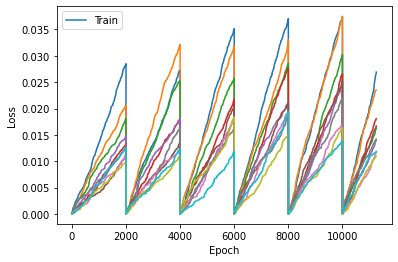

In [29]:
train(10, secondCNN)

In [30]:
accuracy_test(secondCNN)

Accuracy on test images: 57 %


In [31]:
label_accuracy(secondCNN)

Accuracy on label airplane is: 60.9 %
Accuracy on label automobile is: 72.6 %
Accuracy on label bird  is: 45.2 %
Accuracy on label cat   is: 41.9 %
Accuracy on label deer  is: 48.8 %
Accuracy on label dog   is: 50.9 %
Accuracy on label frog  is: 61.9 %
Accuracy on label horse is: 59.7 %
Accuracy on label ship  is: 71.3 %
Accuracy on label truck is: 66.2 %


In [27]:
PATH = './cifar_10_cnnnet.pth'
torch.save(secondCNN.state_dict(), PATH)